In [23]:
# /// script
# requires-python = ">=3.11"
# dependencies = [
#     "numpy",
#     "nibabel",
#     "niworkflows",
#     "nilearn",
#     "pybids",
#     "fitlins",
# ]
# ///
import os
import logging
from pathlib import Path
import bids
import bids.modeling.transformations
from matplotlib import pyplot as plt
import nibabel as nb
from nilearn import glm, plotting
import niworkflows as nw
import niworkflows.data

In [2]:
def get_duration(img_path: os.PathLike | Path) -> float:
    img = nb.load(img_path)
    if img.ndim < 4:
        return 0.0
    return float(img.shape[3] * img.header.get_zooms()[3])

In [28]:
# Ignore this. Just helps makes it so we can use this script as a Jupyter notebook,
# which always sets the CWD to the directory containing the notebook.
if os.getcwd().endswith("code"):
    os.chdir("..")
%matplotlib inline

In [5]:
# Increase log level, but not too much
logging.getLogger().setLevel(logging.INFO)

In [6]:
# Collect raw data and derivatives in a single layout
layout = bids.BIDSLayout("sourcedata/raw")
layout.add_derivatives(
    "sourcedata/fmriprep-patch",
    config=[nw.data.load("nipreps.json")],
    validate=False,
)
logging.info("Loaded BIDS dataset. Found %d files.", len(layout.files))

2024-09-11 08:53:23,689 [    INFO] Loaded BIDS dataset. Found 732 files.


In [7]:
bold_files = layout.get(
    suffix="bold", task="mixed", space="MNI152NLin2009cAsym", extension=".nii.gz"
)

In [8]:
bold_files

[<BIDSImageFile filename='/data/nipreps/bootcamp-geneva-2024-analysis/sourcedata/fmriprep-patch/sub-11/func/sub-11_task-mixed_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'>,
 <BIDSImageFile filename='/data/nipreps/bootcamp-geneva-2024-analysis/sourcedata/fmriprep-patch/sub-14/func/sub-14_task-mixed_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'>,
 <BIDSImageFile filename='/data/nipreps/bootcamp-geneva-2024-analysis/sourcedata/fmriprep-patch/sub-15/func/sub-15_task-mixed_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'>,
 <BIDSImageFile filename='/data/nipreps/bootcamp-geneva-2024-analysis/sourcedata/fmriprep-patch/sub-16/func/sub-16_task-mixed_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'>,
 <BIDSImageFile filename='/data/nipreps/bootcamp-geneva-2024-analysis/sourcedata/fmriprep-patch/sub-17/func/sub-17_task-mixed_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'>]

In [9]:
contrasts = (
    "motor",
    "music",
    "visual",
    "motor - music",
    "motor - visual",
    "music - visual",
)
# PyBIDS doesn't know how to write design matrices or statistical maps.
stat_patterns = [
    "[sub-{subject}/][ses-{session}/][sub-{subject}_][ses-{session}_]task-{task}_[run-{run}_]{suffix<design>}{extension}",
    "[sub-{subject}/][ses-{session}/][sub-{subject}_][ses-{session}_][task-{task}_][run-{run}_]contrast-{contrast}_stat-{stat}_{suffix<statmap>}{extension}",
]

In [10]:
# Collect first-level models as we construct them
first_level_models = []

In [11]:
# Replace loop variable with first value for demonstration
#for bold_file in bold_files:
bold_file = bold_files[0]
if True:
    logging.info("Processing %s...", bold_file.path)
    # Extract entities that identify a given run
    bold_entities = bold_file.get_entities()
    selectors = {
        key: bold_entities[key]
        for key in ("subject", "session", "task", "run")
        if key in bold_entities
    }

    # Collect the scan length from the BOLD file.
    # We will be collecting variables from events.tsv (associated with the raw BOLD)
    # and timeseries.tsv (associated with the resampled BOLD). By default, the scan
    # length is retrieved from the associated BOLD file. We will collect it now so that
    # it is not necessary to have the raw BOLD file downloaded to run this script.
    scan_length = get_duration(bold_file)

    # get_collections() is a general tool that will find *any* variable in BIDS that
    # describes a file or event. It can include sparse variables (onset, duration, *metadata)
    # or dense variables (n vars * t time points). Entities and other metadata fields are
    # also available, but not very useful at the run level, because they are constant within
    # runs. These become more useful at higher levels.
    variables = layout.get_collections(
        level="run", scan_length=scan_length, **selectors
    )[0]

In [12]:
# Show the trial_type variable. This will disappear in the next step.
variables['trial_type'].to_df()

,amplitude,onset,duration,condition,subject,task,suffix,datatype
0,motor,21.2,20.0,trial_type,11,mixed,bold,func
1,music,44.5,20.0,trial_type,11,mixed,bold,func
2,visual,66.9,20.0,trial_type,11,mixed,bold,func
3,motor,89.7,20.0,trial_type,11,mixed,bold,func
4,music,113.0,20.0,trial_type,11,mixed,bold,func
5,visual,135.4,20.0,trial_type,11,mixed,bold,func
6,music,158.2,20.0,trial_type,11,mixed,bold,func
7,visual,180.6,20.0,trial_type,11,mixed,bold,func
8,motor,203.4,20.0,trial_type,11,mixed,bold,func
9,visual,226.7,20.0,trial_type,11,mixed,bold,func


In [13]:
    # There is currently no way in PyBIDS to update the target index with a non-zero
    # onset, so subtract the shift from the onset of the variables.
    # This must be done prior to convolution.
    if start_time := bold_file.get_metadata().get("StartTime"):
        variables["trial_type"].onset -= start_time

    # Transformations are in-place operations:
    #
    # Factor trial_type into dummy variables
    bids.modeling.transformations.Factor(variables, "trial_type")

In [15]:
# trial_type has become trial_type.music, trial_type.motor and trial_type.visual. Note that the events are the same, but amplitude is 0/1
variables['trial_type.music'].to_df()

,amplitude,onset,duration,condition,subject,task,suffix,datatype
0,0.0,20.481,20.0,trial_type.music,11,mixed,bold,func
1,1.0,43.781,20.0,trial_type.music,11,mixed,bold,func
2,0.0,66.181,20.0,trial_type.music,11,mixed,bold,func
3,0.0,88.981,20.0,trial_type.music,11,mixed,bold,func
4,1.0,112.281,20.0,trial_type.music,11,mixed,bold,func
5,0.0,134.681,20.0,trial_type.music,11,mixed,bold,func
6,1.0,157.481,20.0,trial_type.music,11,mixed,bold,func
7,0.0,179.881,20.0,trial_type.music,11,mixed,bold,func
8,0.0,202.681,20.0,trial_type.music,11,mixed,bold,func
9,0.0,225.981,20.0,trial_type.music,11,mixed,bold,func


In [16]:
    # We now have several columns, glob to convolve all of them
    bids.modeling.transformations.Convolve(
        variables, variables.match_variables("trial_type.*")
    )

In [21]:
# After convolution, we have a dense variable, sampled at 10Hz
variables['trial_type.music'].to_df()[['onset', 'duration', 'amplitude']]

,onset,duration,amplitude
0,0.0,0.1,0.0
1,0.1,0.1,0.0
2,0.2,0.1,0.0
3,0.3,0.1,0.0
4,0.4,0.1,0.0
...,...,...,...
4495,449.5,0.1,0.0
4496,449.6,0.1,0.0
4497,449.7,0.1,0.0
4498,449.8,0.1,0.0


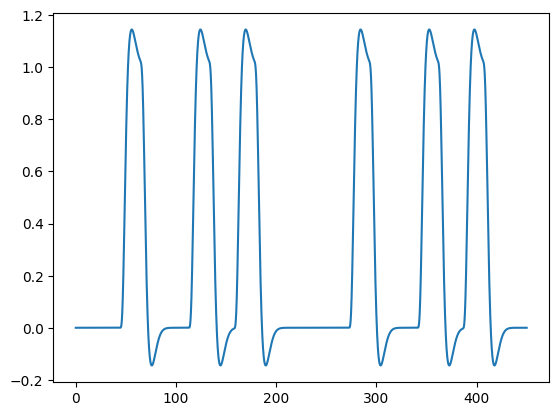

In [34]:
# Plotting this shows the expected HRF-convolved block regressor
plt.plot(*variables['trial_type.music'].to_df()[['onset', 'amplitude']].values.T)

In [35]:
    # variables.to_df aligns all variables to a common index,
    # converting sparse variables to dense, if needed.
    # The special value TR is equivalent to `1./bold_file.get_metadata()['RepetitionTime']`.
    df = variables.to_df(sampling_rate="TR")

    # The design matrix is a DataFrame with the columns of interest, nuissance regressors,
    # and an intercept.
    design_matrix = df[
        variables.match_variables(["trial_type.*", "rot_?", "trans_?"])
    ].assign(intercept=1)

    # Rename columns not to start with trial_type. This makes life easier when writing
    # contrasts as combinations of columns.
    design_matrix.columns = [
        col[11:] if col.startswith("trial_type.") else col
        for col in design_matrix.columns
    ]
    logging.info("Design matrix constructed. Columns: %s", list(design_matrix.columns))

    # Save design matrix
    dmat_fname = bids.layout.writing.build_path(
        {
            "suffix": "design",
            "extension": ".tsv",
            "datatype": "func",
            **selectors,
        },
        path_patterns=stat_patterns,
    )
    Path(dmat_fname).parent.mkdir(parents=True, exist_ok=True)
    design_matrix.to_csv(dmat_fname, sep="\t", index=False)

/home/chris/.cache/uv/environments-v1/5e502f3117ef0a03/6d8cdf4012c0110d/lib/python3.12/site-packages/bids/variables/collections.py:188: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.reset_index().replace("n/a", fillna)


<Axes: label='conditions', ylabel='scan number'>

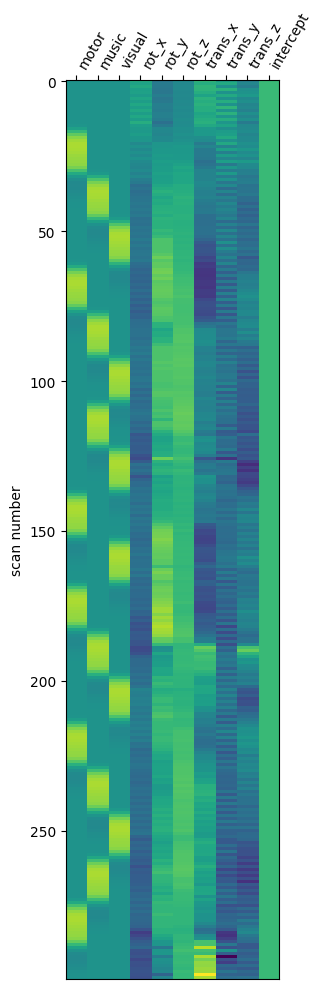

In [36]:
# Use nilearn's plot_design_matrix, which expects a Pandas DataFrame
plotting.plot_design_matrix(design_matrix)

In [39]:
    # Use the FirstLevelModel object, which allows us to nest the results in
    # a SecondLevelModel object below. We don't pass a mask, so that activations
    # outside the brain mask will be obvious and could indicate a preprocessing
    # issue.
    model = glm.first_level.FirstLevelModel(
        smoothing_fwhm=5.0,  # FWHM, this should be a parameter
    )
    first_level_models.append(model)

    # model.fit takes a nibabel image or a path. PyBIDS returns PathLike objects
    # (https://docs.python.org/3/library/os.html#os.PathLike), so we do not
    # need to load the data ourselves.
    model.fit(bold_file, design_matrices=design_matrix)

    logging.info("First level model fit.")

    # Save the effect size and variance of contrasts.
    # This would allow us to run a second-level model without rerunning, if found,
    # but this script currently just recomputes them.
    for contrast in contrasts:
        effect = model.compute_contrast(contrast, output_type="effect_size")
        variance = model.compute_contrast(contrast, output_type="effect_variance")
        contrastValue = "".join(
            ("Vs" if part == "-" else part.capitalize()) for part in contrast.split()
        )
        effect_fname = bids.layout.writing.build_path(
            {
                "suffix": "statmap",
                "extension": ".nii.gz",
                "contrast": contrastValue,
                "stat": "effect",
                **selectors,
            },
            path_patterns=stat_patterns,
        )
        var_fname = bids.layout.writing.build_path(
            {
                "suffix": "statmap",
                "extension": ".nii.gz",
                "contrast": contrastValue,
                "stat": "variance",
                **selectors,
            },
            path_patterns=stat_patterns,
        )
        effect.to_filename(effect_fname)
        variance.to_filename(var_fname)

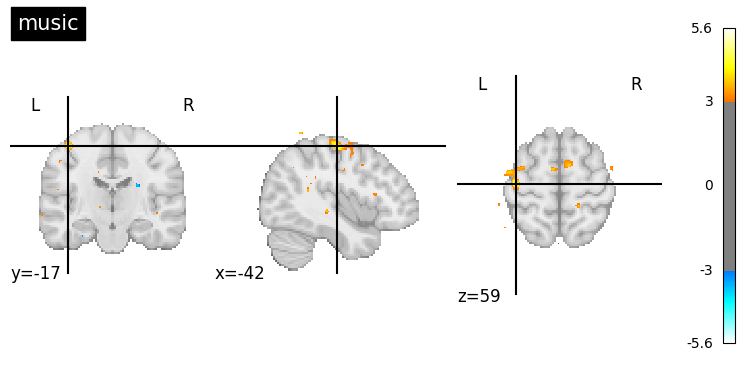

In [40]:
# We can plot any individual contrast. z-score is useful for setting interpretable thresholds.
plotting.plot_stat_map(model.compute_contrast('music', output_type="z_score"), title=f"music", threshold=3)

# If you want to load files with contrast and stat entities, you need a config.
# We could use FitLins' (https://github.com/poldracklab/fitlins/):
import acres

first_level_layout = bids.BIDSLayout(
    '.',
    config=['bids', acres.Loader('fitlins.data').cached('fitlins.json')],
    validate=False,
)
first_level_layout.get(contrast='Motor')  # For example

# Instead we'll just use our list of first-level models...

In [ ]:
logging.info("Running second level model.")

In [ ]:
# Because we did not fit multiple runs, this will not be interesting. Run the regular script now to get a real second-level model.

second_level = glm.second_level.SecondLevelModel()
second_level.fit(first_level_models)

In [ ]:
# This should look familiar from above. Since it's the top-level, we don't need
# any selectors to distinguish one run/session/subject from another.
for contrast in contrasts:
    zscore = second_level.compute_contrast(
        first_level_contrast=contrast, output_type="z_score"
    )
    tdp = glm.cluster_level_inference(zscore, threshold=[1, 2, 3], alpha=0.05)
    contrastValue = "".join(
        ("Vs" if part == "-" else part.capitalize()) for part in contrast.split()
    )
    zscore_fname = bids.layout.writing.build_path(
        {
            "suffix": "statmap",
            "extension": ".nii.gz",
            "contrast": contrastValue,
            "stat": "zscore",
        },
        path_patterns=stat_patterns,
    )
    tdp_fname = bids.layout.writing.build_path(
        {
            "suffix": "statmap",
            "extension": ".nii.gz",
            "contrast": contrastValue,
            "stat": "tdp",
        },
        path_patterns=stat_patterns,
    )
    zscore.to_filename(zscore_fname)
    tdp.to_filename(tdp_fname)

In [ ]:
logging.info("Done!")